In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

time: 930 ms (started: 2022-07-03 09:17:58 +00:00)


# Create Portfolio

out of 505 companies, 150 firms are randomly selected for the portfolio.

In [2]:
df = pd.read_csv("../../stock08_price.csv")
universe = list(df.columns.values[1:])
universe.remove("SP500")
# print(universe)

time: 104 ms (started: 2022-07-03 09:18:20 +00:00)


In [4]:
# train data
portfolio_train = ['CELG', 'PXD', 'WAT', 'LH', 'AMGN', 'AOS', 'EFX', 'CRM', 'NEM', 'JNPR', 'LB', 'CTAS', 'MAT', 'MDLZ', 'VLO', 'APH', 'ADM', 'MLM', 'BK', 'NOV', 'BDX', 'RRC', 'IVZ', 'ED', 'SBUX', 'GRMN', 'CI', 'ZION', 'COO', 'TIF', 'RHT', 'FDX', 'LLL', 'GLW', 'GPN', 'IPGP', 'GPC', 'HPQ', 'ADI', 'AMG', 'MTB', 'YUM', 'SYK', 'KMX', 'AME', 'AAP', 'DAL', 'A', 'MON', 'BRK', 'BMY', 'KMB', 'JPM', 'CCI', 'AET', 'DLTR', 'MGM', 'FL', 'HD', 'CLX', 'OKE', 'UPS', 'WMB', 'IFF', 'CMS', 'ARNC', 'VIAB', 'MMC', 'REG', 'ES', 'ITW', 'NDAQ', 'AIZ', 'VRTX', 'CTL', 'QCOM', 'MSI', 'NKTR', 'AMAT', 'BWA', 'ESRX', 'TXT', 'EXR', 'VNO', 'BBT', 'WDC', 'UAL', 'PVH', 'NOC', 'PCAR', 'NSC', 'UAA', 'FFIV', 'PHM', 'LUV', 'HUM', 'SPG', 'SJM', 'ABT', 'CMG', 'ALK', 'ULTA', 'TMK', 'TAP', 'SCG', 'CAT', 'TMO', 'AES', 'MRK', 'RMD', 'MKC', 'WU', 'ACN', 'HIG', 'TEL', 'DE', 'ATVI', 'O', 'UNM', 'VMC', 'ETFC', 'CMA', 'NRG', 'RHI', 'RE', 'FMC', 'MU', 'CB', 'LNT', 'GE', 'CBS', 'ALGN', 'SNA', 'LLY', 'LEN', 'MAA', 'OMC', 'F', 'APA', 'CDNS', 'SLG', 'HP', 'XLNX', 'SHW', 'AFL', 'STT', 'PAYX', 'AIG', 'FOX', 'MA']
# all data
portfolio_all = universe
# all data - train data
portfolio_other = [p for p in universe if p not in portfolio_train]
print(len(portfolio_train), len(portfolio_all), len(portfolio_other))

150 445 295
time: 1.6 ms (started: 2022-06-26 05:07:48 +00:00)


# Prepare the Data

In [5]:
def rolling_corr(item1,item2) :
    #import data
    stock_price_df = pd.read_csv("../../stock08_price.csv")
    pd.to_datetime(stock_price_df['Date'], format='%Y-%m-%d')
    stock_price_df = stock_price_df.set_index(pd.DatetimeIndex(stock_price_df['Date']))
    
    #calculate
    df_pair = pd.concat([stock_price_df[item1], stock_price_df[item2]], axis=1)
    df_corr = df_pair[item1].rolling(window=100).corr(df_pair[item2])
    return df_corr


def gen_data(portfolio, file_name="", save_file=False):
    index_list = []
    for _ in range(100):
        indices = []
        for k in range(_, 2420,100):
            indices.append(k)
        index_list.append(indices)

    data_matrix = []
    count = 0
    for i in range(len(portfolio)):
        for j in range(len(portfolio)-1-i):
            a = portfolio[i]
            b = portfolio[len(portfolio)-1-j]
            corr_series = rolling_corr(a, b)[99:]
            for _ in range(100):
                corr_strided = list(corr_series[index_list[_]][:24]).copy()
                data_matrix.append(corr_strided)
                count+=1
                if count % 100000 == 0 :
                    print(str(count)+' items preprocessed')

    data_matrix = np.transpose(data_matrix)
    data_dictionary = {}
    for i in range(len(data_matrix)):
        data_dictionary[str(i)] = data_matrix[i]
    data_df = pd.DataFrame(data_dictionary)
    if save_file:
        data_df.to_csv(f'./correlation_record/{file_name}', index=False)
        
    return data_df


def gen_corr_series(data_df=None, file_name="", from_file=False):
    if from_file:
        data_df = pd.read_csv(f'./correlation_record/{file_name}')
        data_df = data_df.loc[:, ~data_df.columns.str.contains('^Unnamed')]
    ind_range = int(len(data_df)/20)
    num_list = []
    for i in range(24):
        num_list.append(str(i))
    data_df = data_df[num_list].copy()
    data_df = np.transpose(data_df)
    indices = [20*k for k in range(ind_range)]
    data_df = pd.DataFrame(data_df[indices])
    return data_df.values.reshape(-1,)



time: 1.44 ms (started: 2022-06-26 05:07:51 +00:00)


In [6]:
gen_from_file = True

if gen_from_file:
    train_corr_series = gen_corr_series(None, "train_dataset.csv", True)
    all_corr_series = gen_corr_series(None, "445_dataset.csv", True)
    other_corr_series = gen_corr_series(None, "295_dataset.csv", True)
else:
    train_data_df = gen_data(portfolio_train) 
    all_data_df = gen_data(portfolio_all) 
    other_data_df = gen_data(portfolio_other) 
    train_corr_series = gen_corr_series(train_data_df)
    all_corr_series = gen_corr_series(all_data_df)
    other_corr_series = gen_corr_series(other_data_df)


time: 34.7 s (started: 2022-06-26 05:07:59 +00:00)


In [7]:
# display(train_data_df.shape, train_data_df)
# display(all_data_df.shape, all_data_df)
# display(other_data_df.shape, other_data_df)
display(train_corr_series.shape, train_corr_series)
display(all_corr_series.shape, all_corr_series)
display(other_corr_series.shape, other_corr_series)

(1341000,)

array([ 0.64686041,  0.51820911,  0.26509852, ..., -0.53164748,
       -0.48467624, -0.72861306])

(11854800,)

array([ 0.49777406,  0.23529682,  0.44683713, ..., -0.43884455,
       -0.61089478, -0.40945352])

(5203800,)

array([-0.33935619, -0.42858279,  0.21048828, ..., -0.43884455,
       -0.61089478, -0.40945352])

time: 5.08 ms (started: 2022-06-26 05:08:33 +00:00)


# plot correlation coffecient distribution of data

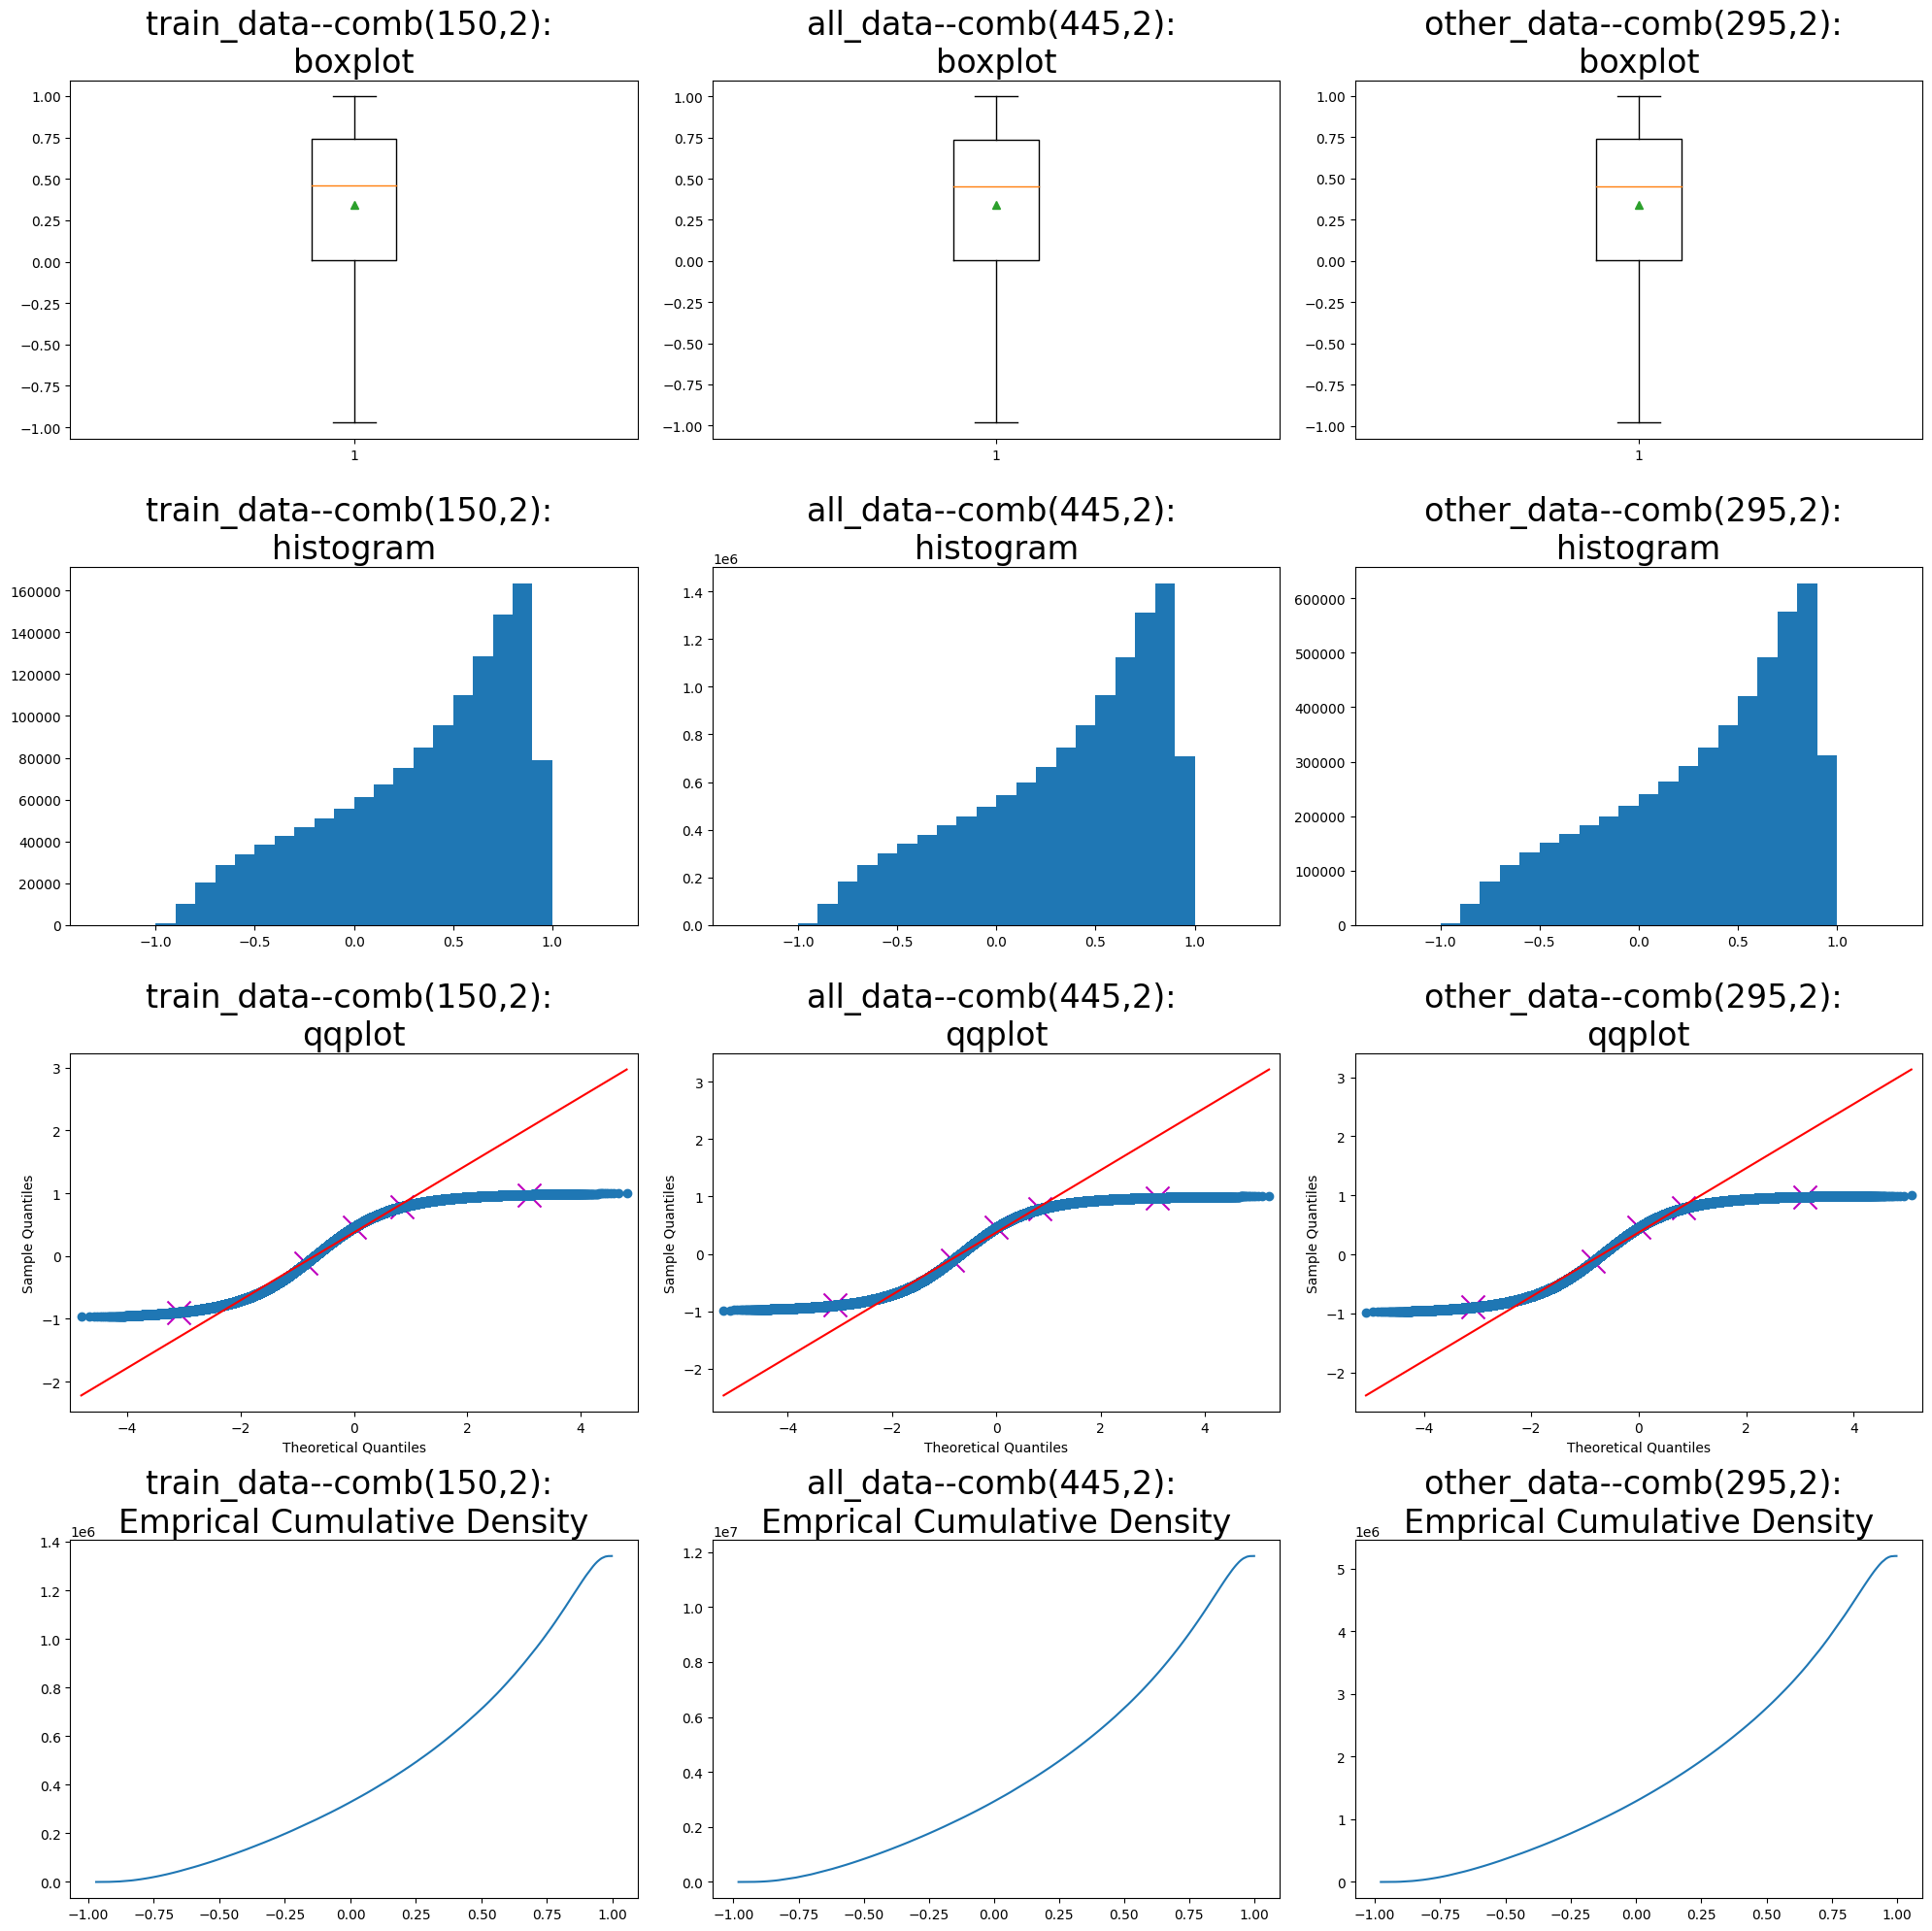

time: 1min 41s (started: 2022-06-26 08:20:45 +00:00)


In [52]:
datasets = {'train_data--comb(150,2)': train_corr_series, 'all_data--comb(445,2)': all_corr_series, 'other_data--comb(295,2)': other_corr_series}
etl_types = ["boxplot", "histogram", "qqplot", "Emprical Cumulative Density"]
fig, axes = plt.subplots(figsize=(20, 20),nrows=len(etl_types), ncols=len(datasets), sharex=False, sharey=False, dpi=100)

for row, etl_type in enumerate(etl_types):
    for col,dataset_key in enumerate(datasets):
        # print(row, etl_type, col, dataset_key, datasets[dataset_key])
        s = axes[row, col]
        s.set_title(f"{dataset_key}: \n{etl_type}", fontsize=24)
        if etl_type=="boxplot":
            s.boxplot(datasets[dataset_key], showmeans=True)
        elif etl_type=="histogram":
            s.hist(datasets[dataset_key], bins=[b/10 for b in range(-13,14)])
        elif etl_type=="qqplot":
            percents = [0.001, 0.2, 0.5, 0.8, 0.999]
            x,y = [norm.ppf(p) for p in percents], [np.quantile(train_corr_series, p) for p in percents]
            sm.qqplot(datasets[dataset_key], line='q', ax=s)
            s.scatter(x,y, c='m', marker='x', s=300)
        elif etl_type=="Emprical Cumulative Density":
            pd.Series(datasets[dataset_key]).value_counts().sort_index().cumsum().plot(ax=s)

# 分開, 避免子圖標籤互相重疊
plt.tight_layout()
plt.savefig("./results/dataset_exploration.png")
plt.show()
plt.close()

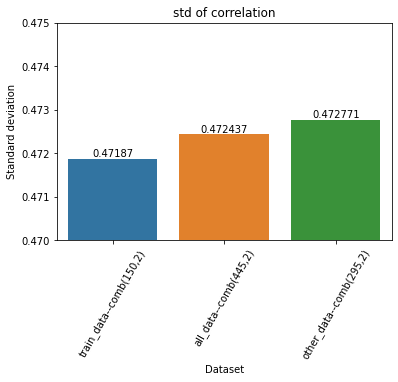

time: 124 ms (started: 2022-06-26 05:34:05 +00:00)


In [19]:
df = pd.DataFrame([[dataset_key, datasets[dataset_key].std()] for dataset_key in datasets], 
                  columns=['Dataset', 'Standard deviation'])
ax = sns.barplot(x='Dataset', y='Standard deviation', data=df)
ax.set_title('std of correlation')
ax.set(ylim=[0.47, 0.475])
ax.bar_label(ax.containers[0])
plt.xticks(rotation=60)
plt.savefig("./results/dataset_exploration_2.png")
plt.show()
plt.close()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

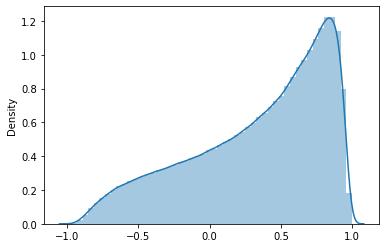

time: 3.25 s (started: 2022-06-26 11:00:01 +00:00)


In [97]:
sns.distplot(train_corr_series)
# plt.hist(train_corr_series, bins=[b/10 for b in range(-13,14)])